# Random sample generation by Gaussian mixture model
Reference:<BR>
https://datachemeng.com/post-3315/<BR>
https://datachemeng.com/inverseanalysis/

In [1]:
# Import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load the dataset

df = pd.read_csv('data_common/df_source.csv')
print(df.shape)
df.head()

(594, 12)


,Kod,GlasNo,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O,E,density,Tg
0,2498,34459,71.01,0.45,0.31,0.0,13.01,12.13,3.08,71.8,2.51,540.0
1,2498,34460,71.77,11.09,0.25,0.0,0.00,9.76,6.29,82.5,2.52,538.0
2,3714,10815,75.01,0.00,0.00,0.0,10.69,14.30,0.00,77.5,2.46,548.0
3,3714,10817,69.93,5.08,0.00,0.0,10.71,14.29,0.00,80.4,2.51,563.0
4,3724,10860,52.50,24.30,0.00,0.0,0.00,23.20,0.00,80.4,2.56,529.0


In [3]:
# Get column number for computation

start = df.columns.get_loc('SiO2')
end   = df.columns.get_loc('K2O') + 1
print('Column the composition starts = ', start)
print('Column the composition ends   = ', end)

Column the composition starts =  2
Column the composition ends   =  9


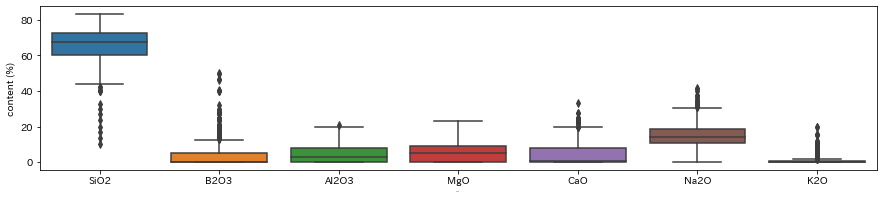

In [4]:
# 組成データの分布の確認

fig = plt.figure(figsize=(15, 3))
sns.boxplot(data = df.iloc[:, start:end])
plt.xlabel('element', fontsize = 0.3)
plt.ylabel('content (%)')
plt.show()

In [5]:
df = df.iloc[:, start:end]
print(df.shape)
df.head()

(594, 7)


,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O
0,71.01,0.45,0.31,0.0,13.01,12.13,3.08
1,71.77,11.09,0.25,0.0,0.00,9.76,6.29
2,75.01,0.00,0.00,0.0,10.69,14.30,0.00
3,69.93,5.08,0.00,0.0,10.71,14.29,0.00
4,52.50,24.30,0.00,0.0,0.00,23.20,0.00


In [6]:
df = df[~df.duplicated()]
print(df.shape)

(547, 7)


# Clustering
Reference:<br>
https://datachemeng.com/post-3315/<br>
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

       SiO2      B2O3     Al2O3       MgO       CaO      Na2O       K2O
0  0.508748 -0.439900 -0.977684 -1.058048  1.390829 -0.325052  0.795762
1  0.585702  0.899873 -0.990931 -1.058048 -0.702427 -0.668560  2.057168
2  0.913771 -0.496563 -1.046124 -1.058048  1.017550 -0.010533 -0.414559
3  0.399392  0.143103 -1.046124 -1.058048  1.020768 -0.011982 -0.414559
4 -1.365495  2.563255 -1.046124 -1.058048 -0.702427  1.279433 -0.414559


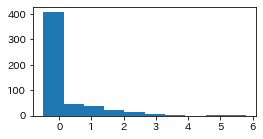

In [7]:
# Scaling

df_std = (df - df.mean(axis=0)) / df.std(axis=0)
df_std = df_std.fillna(0)

print(df_std.head())
plt.figure(figsize=(4,2))
plt.hist(df_std.iloc[:, 1])
plt.show()

# Search the best fit in distributions through BIC

In [8]:
max_number_of_components = 7
covariance_types = ['full', 'diag', 'tied', 'spherical']

np.random.seed(1)

In [9]:
bic_values = np.empty([max_number_of_components, len(covariance_types)])
bic_values.shape

(7, 4)

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from sklearn.mixture import GaussianMixture

# grid search using BIC
for covariance_type_index, covariance_type in enumerate(covariance_types):
    for number_of_components in range(max_number_of_components):
        gmm_model = GaussianMixture(n_components = number_of_components + 1, covariance_type = covariance_type)
        gmm_model.fit(df_std)
        bic_values[number_of_components, covariance_type_index] = gmm_model.bic(df_std)

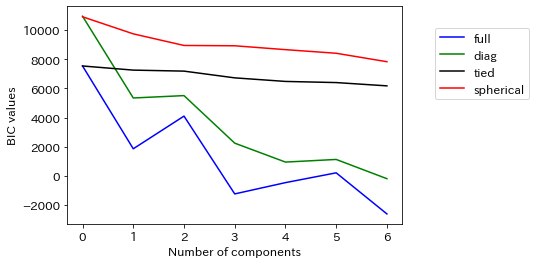

In [12]:
# プロット

plt.rcParams["font.size"] = 12
plt.figure()

plt.plot(bic_values[:, 0], 'b-', label='full')
plt.plot(bic_values[:, 1], 'g-', label='diag')
plt.plot(bic_values[:, 2], 'k-', label='tied')
plt.plot(bic_values[:, 3], 'r-', label='spherical')

plt.xlabel('Number of components')
plt.ylabel('BIC values')
plt.legend(bbox_to_anchor=(0.88, 0.9, 0.5, 0.001), borderaxespad=0., )
plt.show()

In [13]:
# Optimal parameters

optimal_index = np.where(bic_values == bic_values.min())
optimal_number_of_components = optimal_index[0][0] + 1
optimal_covariance_type = covariance_types[optimal_index[1][0]]

print(optimal_index)
print(optimal_number_of_components)
print(optimal_covariance_type)

(array([6], dtype=int64), array([0], dtype=int64))
7
full


In [14]:
# GMM

gmm = GaussianMixture(n_components = optimal_number_of_components, covariance_type = optimal_covariance_type, random_state = 0)
gmm.fit(df_std)

GaussianMixture(n_components=7, random_state=0)

In [15]:
# mean and covariance
means = gmm.means_
if gmm.covariance_type == 'full':
    all_covariances = gmm.covariances_
    
elif gmm.covariance_type == 'diag':
    all_covariances = np.empty(
        [gmm.n_components, gmm.covariances_.shape[1], gmm.covariances_.shape[1]])
    for component_number in range(gmm.n_components):
        all_covariances[component_number, :, :] = np.diag(gmm.covariances_[component_number, :])

elif gmm.covariance_type == 'tied':
    all_covariances = np.tile(gmm.covariances_, (gmm.n_components, 1, 1))
    
elif gmm.covariance_type == 'spherical':
    all_covariances = np.empty([gmm.n_components, gmm.means_.shape[1], gmm.means_.shape[1]])
    for component_number in range(gmm.n_components):
        all_covariances[component_number, :, :] = np.diag(
            gmm.covariances_[component_number] * np.ones(gmm.means_.shape[1]))

# Random sample generation

In [16]:
# sample generation

number_of_samples_generated = 10000

all_samples_generated = np.zeros([0, df.shape[1]])
for component in range(gmm.n_components):
    generated_samples = np.random.multivariate_normal(means[component, :], all_covariances[component, :, :], \
                        int(np.ceil(number_of_samples_generated * gmm.weights_[component])))
    all_samples_generated = np.r_[all_samples_generated, generated_samples]

all_samples_generated = pd.DataFrame(all_samples_generated, columns=df.columns)

all_samples_generated = all_samples_generated * df.std(axis=0, ddof=1) + df.mean(axis=0)

In [17]:
all_samples_generated.head()

,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O
0,58.522015,-5.638777,10.923074,0.006658,0.004914,36.879269,-0.002164
1,48.178489,12.849882,12.191983,-0.006980,0.002777,26.865537,0.000201
2,64.316112,30.091798,0.850872,-0.012146,0.005262,4.386694,0.002631
3,56.546378,10.866688,5.958159,-0.003278,0.003862,26.642347,-0.004309
4,52.341181,10.253035,2.814287,-0.004091,0.007921,34.484836,0.003040


Samples generated for reverse analysis


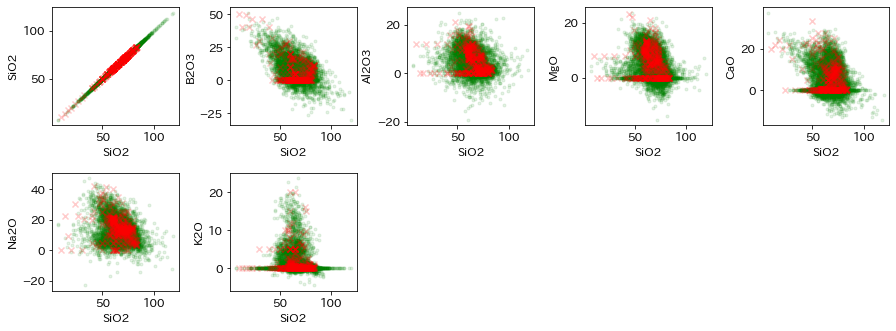

In [18]:
# Plot samples gene

horz = 5
vert = 20
graph_num = horz * vert
axes = list()

print('Samples generated for reverse analysis')
fig = plt.figure(figsize=(15, 60))

for i in range(0, end-start):
    axes.append(fig.add_subplot(vert, horz, i+1))

    x_sample = all_samples_generated.iloc[:, start - 2]
    y_sample = all_samples_generated.iloc[:, i]
    x_train  = df.iloc[:, start - 2]
    y_train  = df.iloc[:, i]
    axes[i].scatter(x_sample, y_sample, c='g', marker = '.', alpha = 0.1)
    axes[i].scatter(x_train, y_train, c='red', marker = 'x', alpha = 0.2)
    axes[i].set_xlabel(df.columns[start - 2], size = 12)
    axes[i].set_ylabel(df.columns[i], size = 12)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

# Correction of negative values because composition should be positive

In [19]:
df_recall = all_samples_generated
print(df_recall.shape)
df_recall.head()

(10002, 7)


,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O
0,58.522015,-5.638777,10.923074,0.006658,0.004914,36.879269,-0.002164
1,48.178489,12.849882,12.191983,-0.006980,0.002777,26.865537,0.000201
2,64.316112,30.091798,0.850872,-0.012146,0.005262,4.386694,0.002631
3,56.546378,10.866688,5.958159,-0.003278,0.003862,26.642347,-0.004309
4,52.341181,10.253035,2.814287,-0.004091,0.007921,34.484836,0.003040


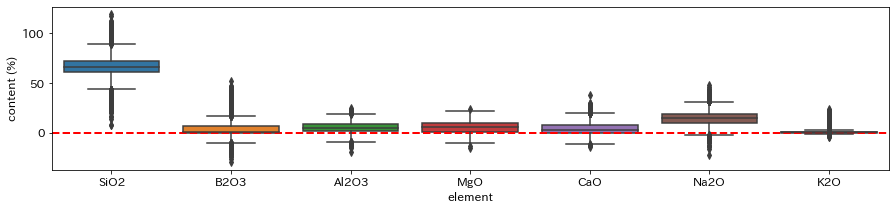

In [20]:
fig = plt.figure(figsize=(15, 3))
sns.boxplot(data=df_recall)
plt.hlines(y=0.0, xmin=-0.5, xmax=6.5, colors='r', linewidths=2, linestyles='dashed')
plt.xlabel('element')
plt.ylabel('content (%)')
plt.show()

# Fill zeros to the negative cells

In [21]:
# Replace negative cells with NaN

df_recall = df_recall[df_recall > 0.0]
print(df_recall.shape)
df_recall.head()

(10002, 7)


,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O
0,58.522015,NaN,10.923074,0.006658,0.004914,36.879269,NaN
1,48.178489,12.849882,12.191983,NaN,0.002777,26.865537,0.000201
2,64.316112,30.091798,0.850872,NaN,0.005262,4.386694,0.002631
3,56.546378,10.866688,5.958159,NaN,0.003862,26.642347,NaN
4,52.341181,10.253035,2.814287,NaN,0.007921,34.484836,0.003040


In [22]:
# Fill zeros

df_recall = df_recall.fillna(0)
print(df_recall.shape)
df_recall.head()

(10002, 7)


,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O
0,58.522015,0.000000,10.923074,0.006658,0.004914,36.879269,0.000000
1,48.178489,12.849882,12.191983,0.000000,0.002777,26.865537,0.000201
2,64.316112,30.091798,0.850872,0.000000,0.005262,4.386694,0.002631
3,56.546378,10.866688,5.958159,0.000000,0.003862,26.642347,0.000000
4,52.341181,10.253035,2.814287,0.000000,0.007921,34.484836,0.003040


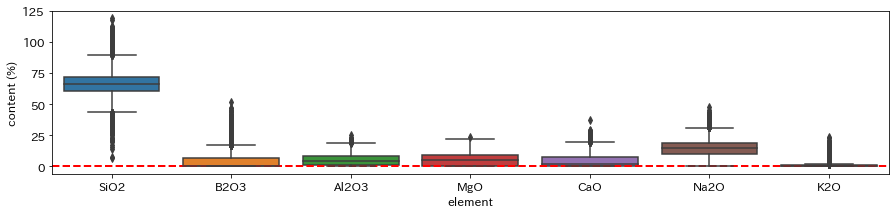

In [23]:
fig = plt.figure(figsize=(15, 3))
sns.boxplot(data=df_recall)
plt.hlines(y=0.0, xmin=-0.5, xmax=6.5, colors='r', linewidths=2, linestyles='dashed')
plt.xlabel('element')
plt.ylabel('content (%)')
plt.show()

In [24]:
# Adjust the total = 100%

df_adj = df_recall.apply(lambda x: 100 * x / np.sum(x), axis=1)
df_adj.head()

,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O
0,55.035034,0.000000,10.272232,0.006262,0.004621,34.681851,0.000000
1,48.135712,12.838472,12.181158,0.000000,0.002774,26.841683,0.000201
2,64.539828,30.196468,0.853831,0.000000,0.005281,4.401952,0.002640
3,56.536522,10.864794,5.957121,0.000000,0.003861,26.637703,0.000000
4,52.391320,10.262857,2.816982,0.000000,0.007928,34.517870,0.003043


Random samples by GMM


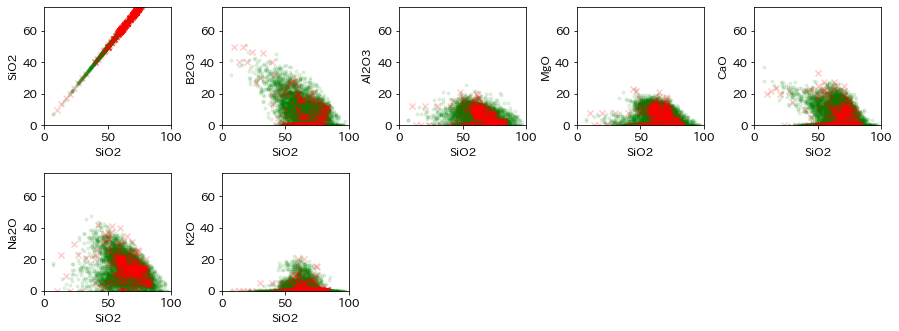

In [25]:
# See distributions

horz = 5
vert = 20
graph_num = horz * vert
axes = list()

print('Random samples by GMM')
fig = plt.figure(figsize=(15, 60))

for i in range(0, end-start):
    axes.append(fig.add_subplot(vert, horz, i+1))

    x_sample = df_adj.iloc[:, start - 2]
    y_sample = df_adj.iloc[:, i]
    x_train  = df.iloc[:, start - 2]
    y_train  = df.iloc[:, i]
    axes[i].scatter(x_sample, y_sample, c='g', marker = '.', alpha = 0.1)
    axes[i].scatter(x_train, y_train, c='red', marker = 'x', alpha = 0.2)
    axes[i].set_xlabel(df.columns[start - 2], size = 12)
    axes[i].set_ylabel(df.columns[i], size = 12)
    axes[i].set_xlim(0, 100)
    axes[i].set_ylim(0, 75)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [26]:
# Save the samples

df_adj.to_csv('./data_common/generated_samples_GMM.csv', index = None)